In [5]:
import pandas as pd
import numpy as np
import ast
import string
import pprint
import nltk
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import cross_validate,StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [7]:
#load the recipes from the DynamoDB CSV exports
indian=pd.read_csv("recipes_indian.csv")
italian=pd.read_csv("recipes_italian.csv")
thai=pd.read_csv("recipes_thai.csv")
chinese=pd.read_csv("recipes_chinese.csv")
french=pd.read_csv("recipes_french.csv")
mexican=pd.read_csv("recipes_mexican.csv")

In [10]:
lemmatizer = WordNetLemmatizer()

#Source for list below
#https://en.wikipedia.org/wiki/Cooking_weights_and_measures
#https://thebakingpan.com/ingredient-weights-and-measures/
measures=['litrbes','liter','millilitres','mL','grams','g', 'kg','teaspoon','tsp', 'tablespoon','tbsp','fluid', 'ounce','oz','fl.oz', 'cup','pint','pt','quart','qt','gallon','gal','smidgen','drop','pinch','dash','scruple','dessertspoon','teacup','cup','c','pottle','gill','dram','wineglass','coffeespoon','pound','lb','tbsp','plus','firmly', 'packed','lightly','level','even','rounded','heaping','heaped','sifted','bushel','peck','stick','chopped','sliced','halves', 'shredded','slivered','sliced','whole','paste','whole',' fresh', 'peeled', 'diced','mashed','dried','frozen','fresh','peeled','candied','no', 'pulp','crystallized','canned','crushed','minced','julienned','clove','head', 'small','large','medium', 'torn', 'cleaned', 'degree']

measures = [lemmatizer.lemmatize(m) for m in measures]
#some of these include data leakage words, like 'italian' 
data_leaks = ['italianstyle', 'french','thai', 'chinese', 'mexican','spanish','indian','italian']

common_remove=['ground','to','taste', 'and', 'or',  'can',  'into', 'cut', 'grated', 'leaf','package','finely','divided','a','piece','optional','inch','needed','more','drained','for','flake','dry','extract','thinly','cubed','bunch','cube','slice','pod','beaten','seeded','uncooked','root','plain','baking','heavy','halved','crumbled','sweet','with','hot','room','temperature','trimmed','allpurpose','deveined','bulk','seasoning','jar','food','if','bag','mix','in','each','roll','instant','double','such','frying','thawed','whipping','stock','rinsed','mild','sprig','freshly','toasted','link','boiling','cooked','unsalted','container',
'cooking','thin','lengthwise','warm','softened','thick','quartered','juiced','pitted','chunk','melted','cold','coloring','puree','cored','stewed','floret','coarsely','the','blanched','zested','sweetened','powdered','garnish','dressing','soup','at','active','lean','chip','sour','long','ripe','skinned','fillet','from','stem','flaked','removed','stalk','unsweetened','cover','crust', 'extra', 'prepared', 'blend', 'of', 'ring',  'undrained', 'about', 'zest', ' ', '', 'spray', 'round', 'herb', 'seasoned', 'wedge', 'bitesize', 'broken', 'square', 'freshly', 'thickly', 'diagonally']
common_remove = [lemmatizer.lemmatize(c) for c in common_remove]
data_leaks = [lemmatizer.lemmatize(d) for d in data_leaks]
# due to using bigrams not including 
useless_singles=['black','white','red','yellow','seed','breast','confectioner','sundried','broth','bell','baby','juice','crumb','sauce','condensed','smoked','basmati','extravirgin','brown','clarified', 'soy', 'filling', 'pine', 'virgin', 'romano', 'heart', 'shell', 'thigh', 'boneless','skinless','split', 'dark', 'wheat', 'light', 'green', 'vegetable', 'curry', 'orange', 'garam', 'sesame', 'strip', 'sea', 'canola', 'mustard','powder', 'ice', 'bay', 'roasted', 'loaf', 'roast', 'powder']
useless_singles = [lemmatizer.lemmatize(u) for u in useless_singles]


In [11]:
def parse_recipes(cuisine, recipe_series):

    for recipe in recipe_series.iteritems():
        ingr_set=ast.literal_eval(recipe[1])
        #print(ingr_set)
        ingr_list=[]
        bigram_list=[]
        for i in ingr_set:
            i.translate(str.maketrans('', '', string.punctuation))
            words=i.split()
            words = [''.join(c for c in word if c not in string.punctuation) for word in words]
            words = [word for word in words if word.isalpha()]
            words = [word.lower() for word in words]
            words = [lemmatizer.lemmatize(word) for word in words]
            words = [word for word in words if word not in measures]

            #first make the bi grams, then remove common words from the single word list
            if(len(words)<3):
                ingr_list.append(' '.join(words))
                ingredients.append(' '.join(words))
            words = [word for word in words if word not in useless_singles]
            for word in words: #not in those single words
                if len(word)>1:
                    ingredients.append(word)
                    ingr_list.append(word)
        #easiest way to deal with any duplicates or blanks for now
            ingr_list=list(set(ingr_list))
            ingr_list = list(filter(None, ingr_list))
#             for bi in bigram_list:
#                 ingredients.append(bi)
        #remove single words here before adding to list of recipe words    
        recipes.append(ingr_list)
        cuisine_labels.append(cuisine)

In [29]:
recipes = []
cuisine_labels = []
ingredients = []
bi_ingredients = []
measures.extend(data_leaks)
measures.extend(common_remove)

parse_recipes('indian', indian['ingredients'])
parse_recipes('italian', italian['ingredients'])
parse_recipes('thai', thai['ingredients'])
parse_recipes('chinese', chinese['ingredients'])
parse_recipes('mexican', mexican['ingredients'])
parse_recipes('french', french['ingredients'])

print("Total ingredients {0}, unique ingredients={1} total recipes {2}".format(len(ingredients), len(set(ingredients)),len(recipes)))
fdist = nltk.FreqDist(ingredients)
df = pd.DataFrame(columns=['word', 'frequency'])

for word, frequency in fdist.most_common(1000):
    print(u'{};{}'.format(word, frequency)) 


Total ingredients 97594, unique ingredients=3647 total recipes 4177
salt;4424
garlic;3991
pepper;3346
onion;3199
oil;2828
tomato;2750
water;2520
cheese;2434
butter;1914
egg;1869
olive;1861
flour;1530
basil;1460
sugar;1394
olive oil;1249
chicken;1218
ginger;1025
oregano;1010
milk;1009
cream;987
parsley;986
white sugar;930
parmesan;846
black pepper;794
parmesan cheese;790
mushroom;743
lemon;726
cilantro;705
cumin;682
beef;666
vegetable oil;654
turmeric;621
wine;604
carrot;594
vanilla;525
pasta;520
cinnamon;506
mozzarella;490
;472
chile;455
bread;442
potato;435
thyme;415
coriander;413
spinach;413
mozzarella cheese;409
sausage;408
vinegar;402
celery;392
rice;391
zucchini;351
red pepper;348
bean;343
almond;341
cornstarch;338
salt pepper;319
spaghetti;316
coconut;315
rosemary;315
pork;307
yogurt;271
lemon juice;264
cardamom;252
nutmeg;250
white wine;248
yeast;242
paprika;234
ricotta;232
lime;230
cayenne;229
green onion;225
cayenne pepper;221
garlic powder;221
chicken broth;221
bacon;214
toma

['indian', 'italian', 'thai', 'chinese', 'mexican', 'french']
[787, 2520, 148, 260, 75, 387]


Text(0.5, 1.0, 'Cuisine (Class) Counts')

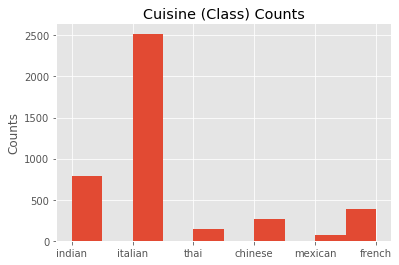

In [30]:
#plot the class counts as a bar chart
from collections import Counter

cuisine_counts = Counter(cuisine_labels)
print(list(cuisine_counts.keys()))
print(list(cuisine_counts.values()))

plt.hist(list(cuisine_counts.keys()), weights=list(cuisine_counts.values()))
plt.ylabel('Counts')
plt.title('Cuisine (Class) Counts')

In [32]:
pp = pprint.PrettyPrinter(indent=4)

#change the list of lists, to list of strings (docs)
recipe_strings=[]
for r in recipes:
    recipe_strings.append(' '.join(r))

skf=StratifiedKFold(n_splits=3)

#baseline, always guessing the dominant class
dc_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('dc', DummyClassifier(strategy='most_frequent', random_state=123))])

print("results for baseline (most frequent) classifier")
pp.pprint(cross_validate(dc_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))


mnb_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('mnb', MultinomialNB())])

print("\nresults for MNB count vector")
pp.pprint(cross_validate(mnb_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))
        
print("\nresults for LR count vector")
lr_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('lr', LogisticRegression( max_iter=1000,random_state=123, multi_class='auto', solver='lbfgs'))])
pp.pprint(cross_validate(lr_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))

        
print("\nresults for LR tfidf vectorizer")
lr_pipe = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2))), ('lr', LogisticRegression( max_iter=1000,random_state=123, multi_class='multinomial', solver='lbfgs'))])
pp.pprint(cross_validate(lr_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))
#worse testing score with ngram_range=(1, 2)

print("\nresults for RF count vector")
rf_pipe= Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('lr', RandomForestClassifier(n_estimators=100, random_state=123))])
pp.pprint(cross_validate(rf_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))
#worse testing scores using bigrams

results for baseline (most frequent) classifier
{   'fit_time': array([0.12600017, 0.09388185, 0.09284973]),
    'score_time': array([0.05071187, 0.04019284, 0.04090619]),
    'test_score': array([0.45367905, 0.45420838, 0.45420838]),
    'train_score': array([0.45420838, 0.4539436 , 0.4539436 ])}

results for MNB count vector
{   'fit_time': array([0.11228204, 0.10390592, 0.10801101]),
    'score_time': array([0.05563188, 0.04439521, 0.05334711]),
    'test_score': array([0.83576921, 0.8467237 , 0.82589937]),
    'train_score': array([0.92702579, 0.92527978, 0.93390352])}

results for LR count vector
{   'fit_time': array([1.64097786, 1.63768291, 1.57493877]),
    'score_time': array([0.04377699, 0.05530715, 0.04636312]),
    'test_score': array([0.85953359, 0.87593782, 0.87241138]),
    'train_score': array([0.99856061, 0.99604469, 0.9960481 ])}

results for LR tfidf vectorizer
{   'fit_time': array([1.02689409, 1.05666494, 1.13821292]),
    'score_time': array([0.05083203, 0.0477829

## Logistic Regression Machine Learning model

In [33]:
cuisines=cuisine_counts.keys()

#confusion matrix to quantify mistakes were made between cuisines
X_train, X_test, y_train, y_test = train_test_split(recipe_strings, cuisine_labels, test_size=0.25, stratify=cuisine_labels, random_state=123)

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


vectorizer = CountVectorizer(ngram_range=(1, 2))

# tokenize and build vocab
matrix_train=vectorizer.fit_transform(X_train)
matrix_test=vectorizer.transform(X_test)
# print(matrix_train[:5])
lr_clf = LogisticRegression( max_iter=1000,random_state=123, multi_class='auto', solver='lbfgs')
lr_clf.fit(matrix_train, y_train)

y_pred = lr_clf.predict(matrix_test)



print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))#,target_names=cuisines))
cm_lr_test=confusion_matrix(y_test, y_pred)
print(cm_lr_test)

 

print("results of using the LR model on the training data:")
y_pred_train = lr_clf.predict(matrix_train)
print('accuracy %s' % accuracy_score(y_pred_train, y_train))
print(classification_report(y_train, y_pred_train))#,target_names=cuisines))
cm_lr_train = confusion_matrix(y_train, y_pred_train)
print(cm_lr_train)

#What was misclassified in the test and train set?
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, y_pred):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the test set:**\n")
for m in misclassifiedIndexes[:10]:
#     if(y_test[m]=='mexican' and y_pred[m]=='italian'):
    print("{0} classified as {1}:\n{2}\n".format(y_test[m],y_pred[m],X_test[m]))


index = 0
misclassifiedIndexes = []
for label, predict in zip(y_train, y_pred_train):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the train set:**\n")
for m in misclassifiedIndexes[:5]:
    print("{0} classified as {1}:\n{2}\n".format(y_train[m],y_pred_train[m],X_train[m])) 
    

accuracy 0.8851674641148325
              precision    recall  f1-score   support

     chinese       0.82      0.72      0.77        65
      french       0.71      0.52      0.60        97
      indian       0.96      0.94      0.95       197
     italian       0.89      0.97      0.93       630
     mexican       1.00      0.53      0.69        19
        thai       0.80      0.65      0.72        37

    accuracy                           0.89      1045
   macro avg       0.86      0.72      0.78      1045
weighted avg       0.88      0.89      0.88      1045

[[ 47   1   2  11   0   4]
 [  1  50   1  45   0   0]
 [  1   1 185   8   0   2]
 [  3  17   1 609   0   0]
 [  0   1   0   8  10   0]
 [  5   0   4   4   0  24]]
results of using the LR model on the training data:
accuracy 0.9971264367816092
              precision    recall  f1-score   support

     chinese       1.00      1.00      1.00       195
      french       1.00      0.99      0.99       290
      indian       0.99

In [35]:
# function to use the matplotlib imgshow to create a heatmap confusion matrix
# taken from here https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html and modified

import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
     
    '''
This function is modified to show the color range as normalized to f1 score
both f1 score and class count are printed in the squares
    '''
    
    if normalize:
        cm_normal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(10, 10))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.imshow(cm_normal, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #using the raw cm so the counts are printed on the heat map
    normalize = False
    
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
    thresh = cm_normal.max() / 2.

    for i, j in itertools.product(range(cm_normal.shape[0]), range(cm_normal.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_normal[i, j] > thresh else "black")
        plt.text(j, i+0.25, format(cm_normal[i, j], '.2f'),
         horizontalalignment="center",
         color="white" if cm_normal[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

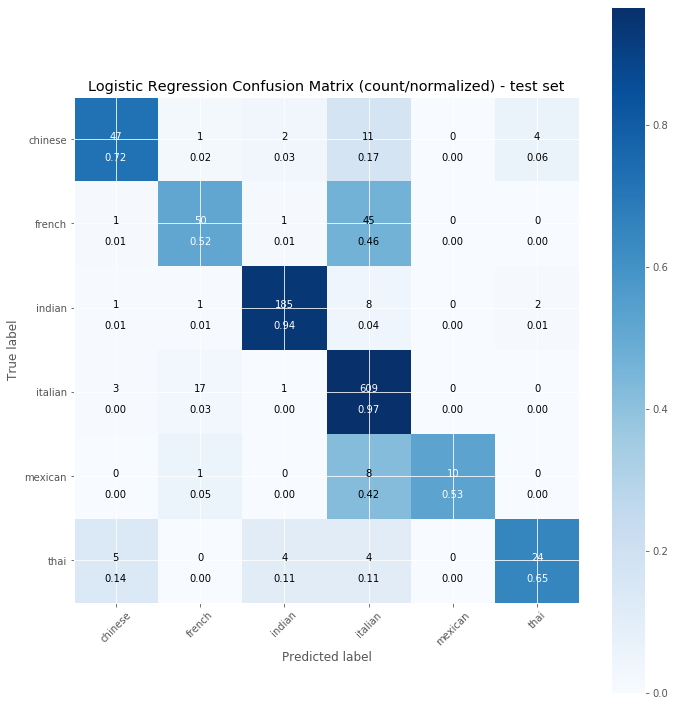

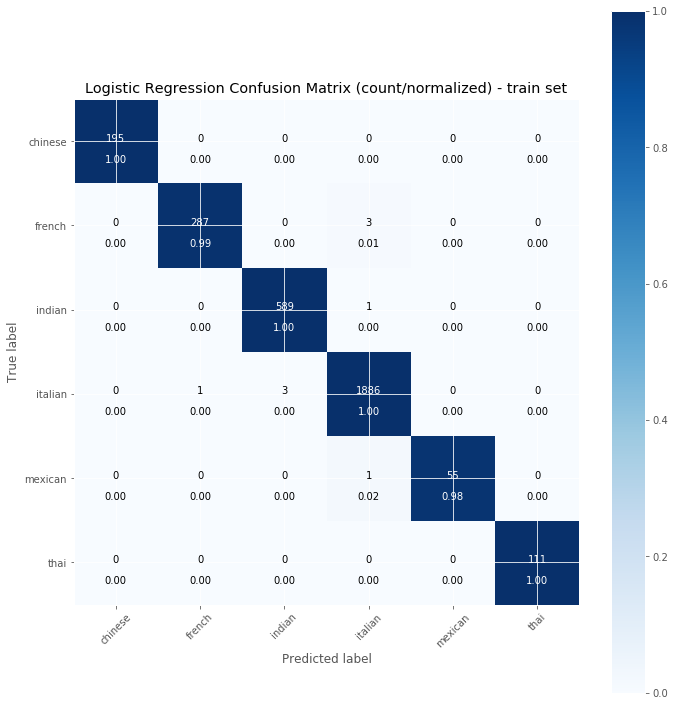

In [36]:
classes=['chinese', 'french','indian','italian','mexican','thai' ]

plot_confusion_matrix(cm_lr_test, classes=classes, normalize=True, title="Logistic Regression Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_lr_train, classes=classes, normalize=True, title="Logistic Regression Confusion Matrix (count/normalized) - train set")